# Problemas de Regressão

Quando precisamos estimar um valor numérico conhecendo certas variáveis, usualmente chamamos de problema de regressão. Alguns exemplos são:

- Estimar o PIB para o próximo ano
- Estimar o preço de um imóvel
- Estimar o valor de abertura de uma ação da bolsa de valores
- Estimar o volume de vendas para o próximo trimestre
- Estimar a temperatura máxima para o próximo dia
- Estimar o score de crédito de um cliente para avaliar empréstimos
- Estimar a demanda de energia elétrica para o próximo mês
- Estimar a nota de uma prova para um aluno
- Estimar o número de ingressos a serem vendidos para um determinado evento
- Estimar a safra de soja para o próximo ano

In [1]:
# bibliotecas

## Estrutura de dados e EDA
import pandas as pd
import numpy as np

## EDA
import matplotlib.pyplot as plt
import seaborn as sns

## Transformers
from sklearn.preprocessing import (
    MinMaxScaler,
    PowerTransformer, 
)

## Train and test
from sklearn.model_selection import train_test_split

## Models
from sklearn.linear_model import LinearRegression

## Metrics
from sklearn.metrics import mean_absolute_error

### Sumário
- Pergunta de negócio
- Objetivo do projeto
- Tipo de problema
- Extração
- Armazenamento
- Carregamento
- Exploração
- Imputação
- Criação de novas variáveis
- Seleção de variáveis
- Transformação
    - Codificação
    - Assimetria
    - Escala
    - Outros tipos de transformação (não veremos por agora)
- Extratificação (não veremos por agora)
- Separação em treino e teste
- Seleção do modelo
- Treinamento
- Predição
- Avaliação
- Tunagem de hiperparâmetros
- Deploy (não veremos)
- Monitoramento (não veremos)

## Pergunta de negócio

Qual valor mediano de uma casa na Califórnia dadas certas características do imóvel tais como localização, número de quartos, idade, etc...?

## Objetivo de negócio

Saber quando investir em um determinado imóvel.

## Tipo de problema

Regressão supervisionada, uma vez que os valores possíveis para a mediana percorrem um intervalo contínuo de números reais. Além disso, já teremos o valor da mediana determinado de acordo com características de uma amostra fornecida previamente.

## Extração

Censo

## Armazenamento

Arquivo .csv disponível em https://github.com/ageron/handson-ml/tree/master/datasets/housing ou, para o original, em https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html ou ainda https://www.kaggle.com/datasets/camnugent/california-housing-prices

## Carregamento

In [2]:
df = pd.read_csv('../datasets/housing.csv')

## Exploração

O objetivo da exploração de dados numa tarefa de aprendizado de máquina é gerar insights para escolha dos métodos de cada uma das próximas etapas da tarefa.

In [3]:
df.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


- Cada linha representa as características de um distrito do estado da Califórnia;
- Dentre as características estão, localização (latitude e longitude), número total de quartos, número total de salas, população, número de casas, renda mediana da população, valor mediano de uma casa e proximidade com o oceano;
- São 10 colunas na tabela;
- A coluna de interesse é a <i>median_house_value</i>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


- A coluna total_bedrooms possuem dados faltantes e deve ser tratada na etapa de imputação
- A coluna ocean_proximity é categórica e deve ser tratada na etapa de codificação
- Utilizaremos 1.6MB para armazenar a tabela na memória

In [5]:
# explorando categóricas (estatísticas)
df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

- São 5 categorias de proximidade do oceano;
- A categoria mais frequente é "<1H OCEAN" com 9136 unidades amostrais, isto é, 9136 distritos estão a menos de uma hora do oceano;
- A categoria menos frequente é "ISLAND" com 5 unidades amostrais. Logo, 5 distritos estão em ilhas;

In [6]:
# explorando numéricas (estatísticas)
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


- O preço mediano não faz sentido em dólares. Segundo o livro texto, as escalas foram alteradas de 10000 para 1. Logo o preço mediano é de 35 mil dólares.
- Segundo o livro texto, os valores de idade mediana e preço mediano foram limitados durante o censo. Essas limitações podem ser refletidas no resultado final.

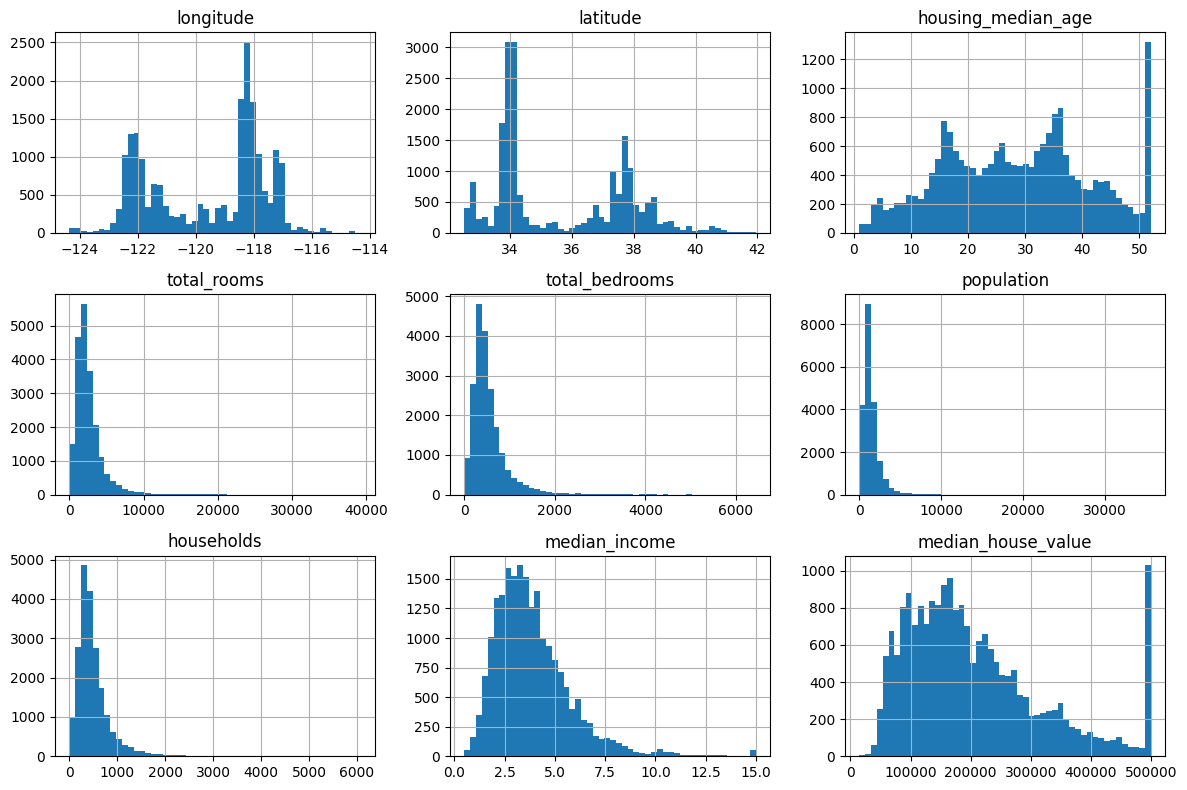

In [7]:
# explorando numéricas (gráficos)
df.hist(bins=50, figsize=(12, 8))
plt.tight_layout()
plt.show()

- Há várias distribuições assimétricas o que indica que modelos que tenham como hipótese que os dados sejam normais podem apresentar resultados insatisfatórios
- Transformar estas variáveis na etapa de transformação

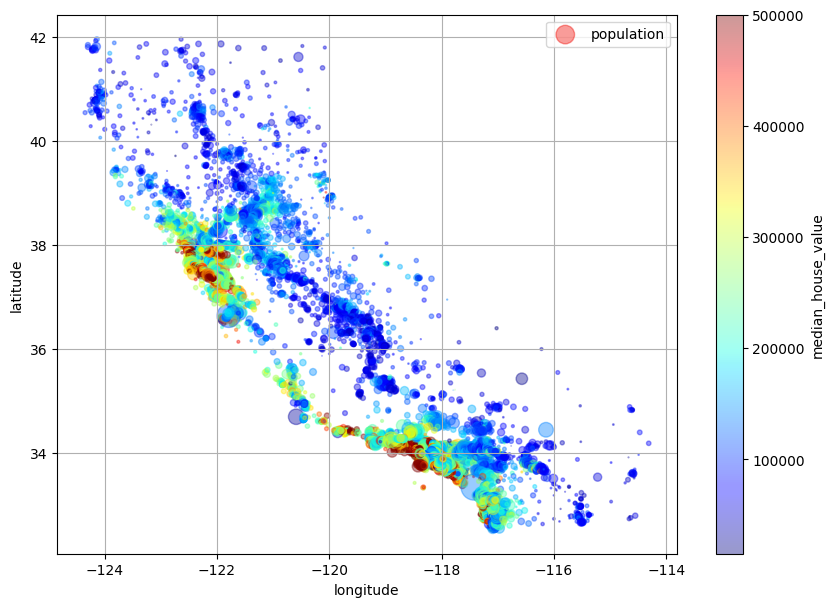

In [8]:
# Análise multivariada
# latitude, longitude, population e median_house_value
scaled_population = df["population"] / 100
df.plot(
    kind="scatter", x="longitude", y="latitude", grid=True,
    s = scaled_population, label="population",
    c="median_house_value", cmap="jet", colorbar=True,
    legend=True, sharex=False, figsize=(10, 7),alpha=0.4)
plt.show()

- Latitudes e longitudes dos distritos estão distribuídos de maneira significativamente densa no estado da Califórnia, esta afirmação pode ser confirmada pelo gráfico acima que lembra o mapa do estado da Califórnia.
- Distritos mais populosos e mais próximos ao oceano possuem maior valor mediano de casas

In [9]:
# correlações com variável de interesse
corr_matrix = df.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

- Há uma correlação de 0.68 entre o valor mediano de uma casa e a renda mediana da população.
- Valores muito próximos de zero significam que não há forte correlação linear entre as variáveis.

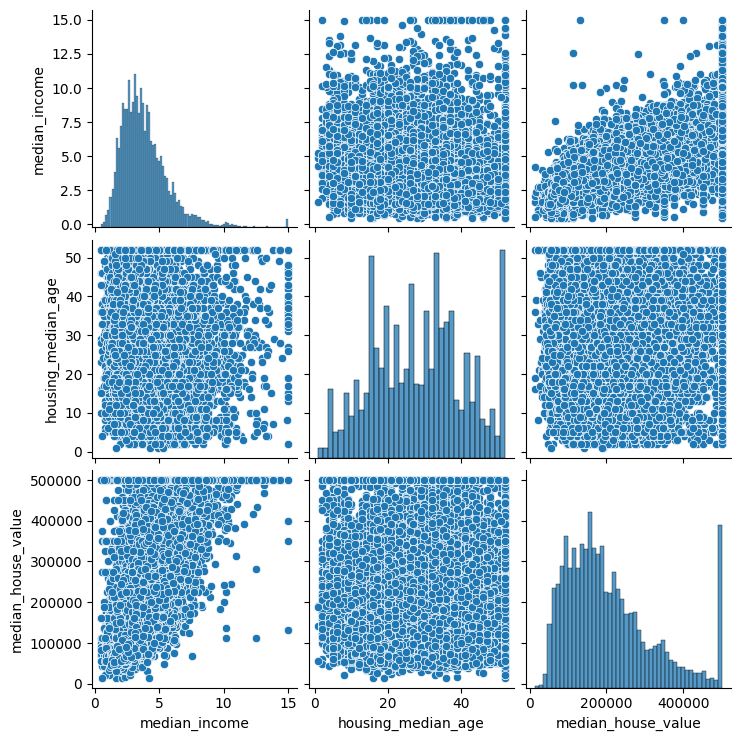

In [10]:
# Correlações com variável de interesse (visual)
sns.pairplot(df[['median_income', 'housing_median_age', 'median_house_value']])
plt.show()

- Retas horizontal aparecem em torno de 450,000 dólares e 350,000 dólares no gráfico de median_house_value X median_income. Esses valores podem influenciar modelos menos robustos;
- Os gráficos mostram claramente um concentração maior nos valores limitados pela pesquisa. Essa concentração também interfere no desempenho de modelos menos robustos;

# Imputação

Preencheremos os valores faltantes utilizando alguma das técnicas apropriadas. Uma delas e, talvez, a mais simples, é substituir os valores faltantes por uma constante. Quando os valores faltantes são numéricos é comum substituir pela mediana.

In [11]:
median = df["total_bedrooms"].median() 
df["total_bedrooms"].fillna(median, inplace=True)

## Criação de novas variáveis

É comum acrescentar novas colunas ao Data Frame. Tal estratégia pode ser feita combinando dados externos, combinando dados internos e, até mesmo, combinando dados externos e internos. Para esse estudo de caso criaremos duas novas colunas, a saber, o número médio de cômodos por casas e a proporção de quartos em relação ao número de cômodos na casa.

In [12]:
df["rooms_per_house"] = df["total_rooms"] / df["households"]
df["bedrooms_ratio"] = df["total_bedrooms"] / df["total_rooms"]

In [13]:
# correlações com variável de interesse
corr_matrix = df[[
    "rooms_per_house", "total_rooms","bedrooms_ratio","total_bedrooms","median_house_value"
]].corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
rooms_per_house       0.151948
total_rooms           0.134153
total_bedrooms        0.049457
bedrooms_ratio       -0.233303
Name: median_house_value, dtype: float64

- Observe que ambas correlações obtidas nas novas colunas são expressivas que as correlações obtidas das colunas originais utilizadas para criação das novas; 

## Seleção de variáveis

In [14]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'rooms_per_house',
       'bedrooms_ratio'],
      dtype='object')

In [15]:
df.drop(['total_bedrooms', 'total_rooms'], axis=1, inplace=True)

- Fizemos descarte de variáveis já explicadas por outras variáveis e que tem correlação menos expressiva. Existem diversas outras técnicas de seleção de variáveis.

## Transformações

Dada uma coluna $X$ do Data Frame estudado, é importante considerar as transformações de $X$. Podemos definir uma transformação de $X=(x_1, \ldots, x_n)$ como sendo $f(X) = (f(x_1),\ldots, f(x_n))$ para alguma função $f$ qualquer. Transformações são importantes para que os algoritmos não fiquem enviesados.

### Codificação

A maioria dos modelos consideram apenas variáveis numéricas, logo temos que transformar a variável categórica <i>ocean_proximity</i> em variável numérica.

Uma maneira de fazer isso é aplicando uma técnica conhecida por Dummies.

In [16]:
dummies = pd.get_dummies(df['ocean_proximity'])
dummies

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0
...,...,...,...,...,...
20635,0,1,0,0,0
20636,0,1,0,0,0
20637,0,1,0,0,0
20638,0,1,0,0,0


Se não estiver a menos de uma hora do oceano, nem próximo a bahia, nem próximo ao oceano e nem em uma ilha, consequentemente estará INLAND. Isso quer dizer que as outras 4 variáveis explicam a variável INLAND. Podemos então descartá-la para evitar redundâncias e baixo desempenho do nosso modelo.

In [17]:
dummies.drop('INLAND', axis=1, inplace=True)

Agora é só adicionar os Dummies ao Data Frame original

In [18]:
df[dummies.columns] = dummies
df.head()

,longitude,latitude,housing_median_age,population,households,median_income,median_house_value,ocean_proximity,rooms_per_house,bedrooms_ratio,<1H OCEAN,ISLAND,NEAR BAY,NEAR OCEAN
0,-122.23,37.88,41.0,322.0,126.0,8.3252,452600.0,NEAR BAY,6.984127,0.146591,0,0,1,0
1,-122.22,37.86,21.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,6.238137,0.155797,0,0,1,0
2,-122.24,37.85,52.0,496.0,177.0,7.2574,352100.0,NEAR BAY,8.288136,0.129516,0,0,1,0
3,-122.25,37.85,52.0,558.0,219.0,5.6431,341300.0,NEAR BAY,5.817352,0.184458,0,0,1,0
4,-122.25,37.85,52.0,565.0,259.0,3.8462,342200.0,NEAR BAY,6.281853,0.172096,0,0,1,0


Podemos agora descartar a coluna <i>ocean_proximity</i>

In [19]:
df.drop('ocean_proximity', axis=1, inplace=True)

- Outras codificações que podem ser consideradas nessa etapa: oneHotEncoding e OrdinalEncoding

### Assimetria

Podemos calcular a assimetria de cada coluna.

In [20]:
def compute_skew(serie):
    return 3 * (serie.mean() - serie.median()) / serie.std()

for col in df.columns:
    print(col, compute_skew(df[col]))

longitude -1.616701814149639
latitude 1.9268146177907624
housing_median_age -0.08593506390480503
population 0.6873786041909128
households 0.7104313454184753
median_income 0.5303724024224249
median_house_value 0.705983932833341
rooms_per_house 0.24234878852264918
bedrooms_ratio 0.4889780186467477
<1H OCEAN 2.67340245601974
ISLAND 0.04669748586604987
NEAR BAY 1.0597671188705322
NEAR OCEAN 1.1533715257199035


Com exceção de ISLAND e housing_median_age, todas as outras colunas possuem assimetria. Trateremos duas delas, a saber, median_income e 

Para tratar median_income utilizaremos transformação por potência.

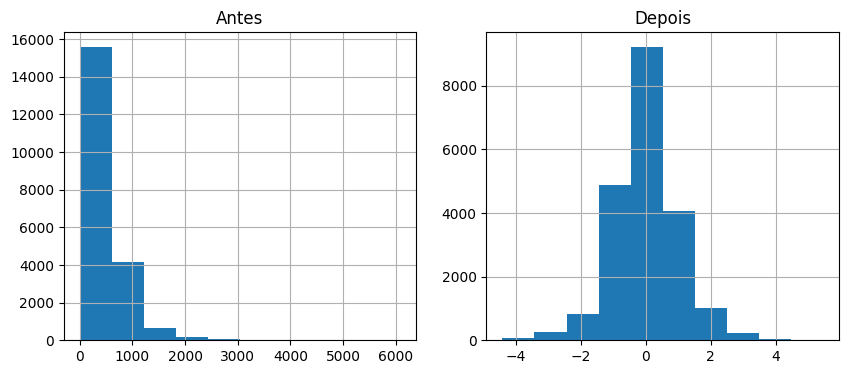

In [21]:
pt = PowerTransformer()
new_income = pd.Series(pt.fit_transform(df[['households']]).ravel())

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
df['households'].hist()
plt.title("Antes")
plt.subplot(1,2,2)
new_income.hist()
plt.title("Depois")
plt.show()

Podemos observar como a assimetria é tratada visualmente. Agora substituiremos a variável antiga pela variável tratada.

In [22]:
df['households'] = new_income
compute_skew(df['households'])

0.12367601213898591

Para tratar median_house_value utilizaremos transformação com quantil.

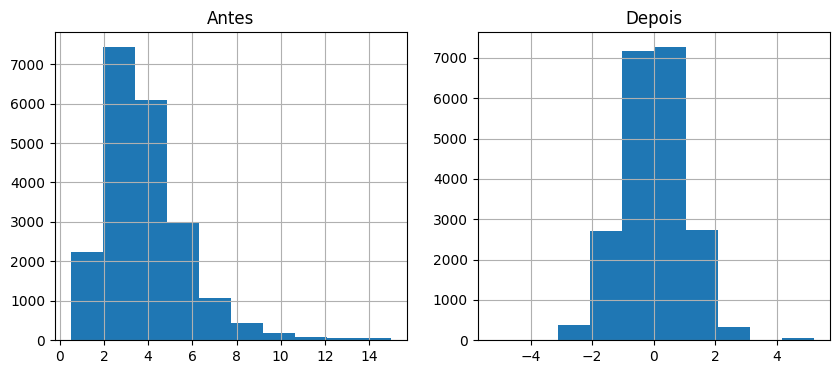

In [23]:
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal')
new_house_value = pd.Series(qt.fit_transform(df[['median_income']]).ravel())

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
df['median_income'].hist()
plt.title("Antes")
plt.subplot(1,2,2)
new_house_value.hist()
plt.title("Depois")
plt.show()

- Já vemos o efeito da limitação nos valores das casas e na aglomeração de valores em torno de 500000 em transformações.

In [24]:
df['median_income'] = new_house_value
compute_skew(df['median_income'])

0.0030145101875332057

Ambas técnicas diminuíram consideravelmente a assimetria de ambas as variáveis. Existem diversas outras técnicas.

### Escala

É possível ajustar as escalas dos dados de diversas formas, isso faz com que as variáveis tenham mesma ordem de grandeza. Para este estudo vamos subtrair o mínimo e dividir o resultado pela diferença do máximo pelo mínimo. Este processo também é chamado de normalização.

$$f(X) = \frac{X - min(X)}{max(X) - min(X)}$$

In [25]:
# instancia o método para ajuste de escala
scaler = MinMaxScaler()
# ajusta o método aos dados
scaler.fit(df)
# transforma os dados
X = scaler.transform(df)
# sobrescreve o Data Frame
df = pd.DataFrame(X, columns=df.columns)

In [26]:
df.describe()

,longitude,latitude,housing_median_age,population,households,median_income,median_house_value,rooms_per_house,bedrooms_ratio,<1H OCEAN,ISLAND,NEAR BAY,NEAR OCEAN
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,0.476125,0.328572,0.541951,0.039869,0.447366,0.500837,0.395579,0.032488,0.063369,0.442636,0.000242,0.110950,0.128779
std,0.199555,0.226988,0.246776,0.031740,0.101600,0.098969,0.237928,0.017539,0.023407,0.496710,0.015563,0.314077,0.334963
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.253984,0.147715,0.333333,0.021974,0.390046,0.434169,0.215671,0.025482,0.049533,0.000000,0.000000,0.000000,0.000000
50%,0.583665,0.182784,0.549020,0.032596,0.443178,0.500737,0.339588,0.031071,0.059554,0.000000,0.000000,0.000000,0.000000
75%,0.631474,0.549416,0.705882,0.048264,0.503407,0.565441,0.514897,0.036907,0.072816,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot: >

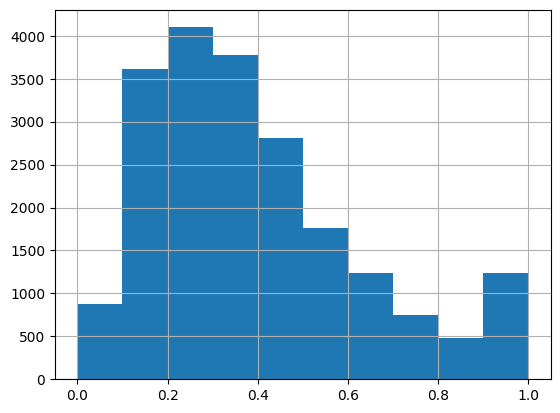

In [27]:
df['median_house_value'].hist()

- Observe que o mínimo de todas as variável é zero e o máximo é sempre 1, logo agora todas as variáveis possuem mesma ordem de grandeza;
- Se a distribuição não é Gaussiana ou o desvio padrão é muito pequeno, normalizar os dados é uma escolha a ser tomada;
- Fonte: https://medium.com/data-hackers/normalizar-ou-padronizar-as-vari%C3%A1veis-3b619876ccc9

## Extratificação

A partir desse ponto separaremos os dados em conjunto de treino e conjunto de teste. No conjunto de treino, treinaremos nossos modelos. No conjunto de testes, faremos as avaliações dos nossos modelos.

In [28]:
# Extratificação considerando intervalos
df["income_cat"] = pd.cut( # assegura que o teste é representativo
    df["median_house_value"],
    bins=[-0.99, 0.2, 0.4, 0.6, 0.8, 1.1],
    labels=[1, 2, 3, 4, 5])

# Treino e teste com extratificação
strat_train_set, strat_test_set = train_test_split(
    df, test_size=0.2, stratify=df["income_cat"], random_state=42)

# Remove a coluna usada apenas para extratificação
strat_train_set.drop("income_cat", axis=1, inplace=True)
strat_test_set.drop("income_cat", axis=1, inplace=True)

## Treino e teste

In [29]:
X_train = strat_train_set.drop("median_house_value", axis=1) # train features
y_train = strat_train_set["median_house_value"] # train target

X_test = strat_train_set.drop("median_house_value", axis=1) # test features
y_test = strat_train_set["median_house_value"] # test target

## Seleção do modelo

In [30]:
model = LinearRegression()

## Treinamento do modelo

In [31]:
# train model
model.fit(X_train, y_train)

LinearRegression()

## Predições

In [32]:
# get prediciont on test
y_pred = model.predict(X_test)

## Avaliação das predições

In [33]:
mae = mean_absolute_error(y_test, y_pred)
print("MAE", mae)

MAE 0.11386120284096779


## Exercício 1

Faça uma submissão de uma solução no site Kaggle para o seguinte problema:

https://www.kaggle.com/competitions/playground-series-s3e1

### Resposta:

In [34]:
import pandas as pd

# carregando os dados
df_train = pd.read_csv('../datasets/california_housing_kaggle/train.csv')
df_test = pd.read_csv('../datasets/california_housing_kaggle/test.csv')

# imputação
df_train.fillna(method='ffill')
df_test.fillna(method='ffill')

# seleção de colunas
df_train.drop('id', axis=1, inplace=True)

# Treino e teste
from sklearn.model_selection import train_test_split
X = df_train.drop('MedHouseVal', axis=1)
y = df_train['MedHouseVal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Selecionar modelo
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()

# Treinar modelo
model.fit(X_train, y_train)

# Criar predições
y_pred = model.predict(X_test)

# Root Mean Squared Error (RMSE)
from sklearn.metrics import mean_squared_error
print("Avaliação do modelo:", mean_squared_error(y_pred, y_test))

Avaliação do modelo: 0.36792831350678523


In [35]:
# Submissão do modelo
X_submission = df_test.drop('id', axis=1)
y_submission = model.predict(X_submission)
submission = pd.DataFrame({
    'id': df_test['id'],
    'MedHouseVal': y_submission
})

submission.to_csv('sub_california_housing.csv', index=None)

Public score: 0.6027<br>
Private score: 0.60019

## Exercício 2

Tente atingir uma pontuação abaixo de 0.58 nesta mesma competição!

<b>Dics:</b> Mude o modelo.

# Referência

- Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems, Autor Aurélien Géron, Edição	2, Editora	"O'Reilly Media, Inc.", 2019